In [2]:
# tudo o que tem no SimulacaoCaoticaGeral.py
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def dYdt( t, Y, \
         amp = lambda t, Y, **kwrd: 1.3, \
         far = lambda t, Y, **kwrd: -.05*Y[0], \
         esp = lambda t, Y, **kwrd: -np.sin(2*np.pi*Y[1]), \
         gef = 1, calculaEq = False, **kwrd ):
  if calculaEq:
    fun2solve = lambda z:dYdt( t=t, Y=[0,z], amp=amp, esp=esp, far=far, gef=gef, **kwrd )[0]
    zEq = fsolve( fun2solve, Y[1] )[0]
    return zEq
  v, z = Y
  dvdt = amp(t,Y,**kwrd)*esp(t,Y,**kwrd) - gef + far(t,Y,**kwrd)
  dzdt = v
  return [dvdt, dzdt]

def resolve( funR=dYdt, t_span = [0., 40.], y0='Eq', dt = 0.1, \
            events=None, rtol=1e-6, atol=1e-9, max_step=np.inf, \
            method='DOP853', SHOW=True, RETORNA=False, **kwrd ):
  if (y0=='Eq'):
    z0 = funR( t=-1, Y=[0, 0], calculaEq=True, **kwrd )
    v0 = 0.
    y0Ef = [v0, z0]
  else:
    y0Ef = y0.copy()

  # print( f'{y0Ef = }' )
  t_eval=np.arange(t_span[0], t_span[-1]+dt, dt)
  t_eval = t_eval[t_eval<=t_span[-1]]
  SOL = solve_ivp( fun=lambda t, Y: funR(t,Y,**kwrd), t_span=t_span, \
                   y0=y0Ef, method=method, t_eval=t_eval, \
                   max_step=max_step, rtol=rtol, atol=atol, events=events )

  if SHOW:
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot( SOL.t, SOL.y[0], '.-' )
    plt.ylabel( 'v' )
    plt.subplot(2,1,2)
    plt.plot( SOL.t, SOL.y[1], '.-' )
    plt.ylabel( 'z' )
    plt.xlabel( 't' )
    plt.show()
  if RETORNA:
    return SOL

def fazOff(t, Y, dtOff=.05, tIni=0, ampOn=1.3, DT=None, **kwrd):
  tEf = (t-tIni)
  if (tEf<0) or (dtOff is None):
    return ampOn
  if DT is not None:
    tEf = tEf % DT
  if tEf>=0. and tEf<=dtOff:
    return 0.
  else:
    return ampOn


def eventoExtremo(t, Y):
  v, z = Y
  return v

In [3]:
t_span = [0, 10]
t_eval = np.arange(1,9+1,1.0)
SOL = solve_ivp( fun=lambda t, Y: -.01*Y[0], t_span=t_span, \
                   y0=[100], method='DOP853', t_eval=None, dense_output=False )
print( SOL )

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.217e-01  4.639e+00  1.000e+01]
        y: [[ 1.000e+02  9.958e+01  9.547e+01  9.048e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 38
     njev: 0
      nlu: 0


In [72]:
def resolveEmPassos( funR=dYdt, t_span = [0., 40.], y0='Eq', dt = 0.1, \
                    tPIni = 0, dtP = None, DTP = None, \
                    events=None, rtol=1e-6, atol=1e-9, max_step=np.inf, \
                    method='DOP853', SHOW=True, RETORNA=False, \
                    kwrd_dtP={}, kwrd_DTP={}, **kwrd ):
  if (y0=='Eq'):
    z0 = funR( t=tPIni-1, Y=[0, 0], calculaEq=True, **kwrd )
    v0 = 0.
    y0Ef = [v0, z0]
  else:
    y0Ef = y0.copy()

  T_EVALs = []
  Y_EVALs = []
  if events is not None:
    try:
       nada = len(events)
    except:
      events = [events]
    T_EVENTSs = [[]]*len(events)
    Y_EVENTSs = [[]]*len(events)
  NFEVs = []
  NJEVs = []
  NLUs = []
  T_SPANs = []

  t_atu = 1.0*t_span[0]
  #T_EVALs.append(t_atu)
  #Y_EVALs.append(y0Ef.copy())
  #next_t_eval = t_atu + dt
  next_t_eval = t_span[0]
  if dtP is None:
    # Se não houver indicação de duração de solução diferenciada, faz a
    #  integração em uma única etapa
    t_span_atu = t_span.copy()
    tipo_intervalo = 2
    proximo_intervalo = 0
  elif t_atu<tPIni:
    # Se o tempo for anterior ao início da integração por passos
    t_span_atu = [t_atu, tPIni]
    tipo_intervalo = 2
    proximo_intervalo = 1
  elif (DTP is None):
    # Se não houver periodicidade, o que importa é saber se esta dentro do
    #  intervalo de tempo de solução diferenciada
    if (t_atu-tPIni) < dtP:
      t_span_atu = [t_atu, tPIni + dtP]
      tipo_intervalo = 1
      proximo_intervalo = 0
    else:
      t_span_atu =  t_span.copy()
      tipo_intervalo = 2
      proximo_intervalo = 0
  elif (t_atu-tPIni)%DTP < dtP:
    # Se o tempo estiver na parte da solução dtP
    t_span_atu = [t_atu, tPIni + DTP*np.fix((t_atu-tPIni)/DTP) + dtP]
    tipo_intervalo = 1
    proximo_intervalo = 2
  else: # Se o tempo estiver na parte da solução não dtP
    t_span_atu = [t_atu, tPIni + DTP*(1+np.fix((t_atu-tPIni)/DTP))]
    tipo_intervalo = 2
    proximo_intervalo = 1

  while t_atu<t_span[-1]:
    T_SPANs.append(t_span_atu.copy())
    if tipo_intervalo==1:
      kwrd_atu =  {**kwrd, **kwrd_dtP}
    else:
      kwrd_atu = {**kwrd, **kwrd_DTP}

    SOL_ATU = solve_ivp( fun=lambda t, Y: funR(t,Y,**kwrd_atu), t_span=t_span_atu, \
                   y0=y0Ef, method=method, dense_output=True, \
                   max_step=max_step, rtol=rtol, atol=atol, events=events )
    y0Ef = SOL_ATU.y[:,-1]
    while( next_t_eval<=t_span_atu[-1] ):
      t_eval_atu = next_t_eval
      T_EVALs.append(t_eval_atu)
      Y_EVALs.append( SOL_ATU.sol(t_eval_atu) )
      next_t_eval = t_eval_atu + dt

    if SOL_ATU.t_events is not None:
      for i_ev in range(len(SOL_ATU.t_events)):
        for t_e_i in SOL_ATU.t_events[i_ev]:
          T_EVENTSs[i_ev].append( t_e_i )
        for y_e_i in SOL_ATU.y_events[i_ev]:
          Y_EVENTSs[i_ev].append( y_e_i )
    NFEVs.append(SOL_ATU.nfev)
    NJEVs.append(SOL_ATU.njev)
    NLUs.append(SOL_ATU.nlu)

    t_atu = t_span_atu[-1]
    if proximo_intervalo==0:
      t_span_atu = [t_atu, t_span[-1]]
    elif proximo_intervalo==1:
      t_span_atu = [t_atu, min(t_atu+dtP,t_span[-1])]
      tipo_intervalo = 1
      proximo_intervalo=2
    elif proximo_intervalo==2:
      t_span_atu = [t_atu, min(t_atu+(DTP-dtP),t_span[-1])]
      tipo_intervalo = 2
      proximo_intervalo=1

  SOL = SOL_ATU
  SOL.t = np.array( T_EVALs )
  SOL.y = np.array( Y_EVALs ).T
  SOL.sol = None
  if events is not None:
    SOL.t_events=[]
    SOL.y_events=[]
    for i_ev in range(len(events)):
      SOL.t_events.append( np.array( T_EVENTSs[i_ev] ) )
      SOL.y_events.append( np.array( Y_EVENTSs[i_ev] ) )
  else:
    SOL.t_events = None
    SOL.y_events = None
  SOL.nfev = np.sum(NFEVs)
  SOL.njev = np.sum(NJEVs)
  SOL.nlu = np.sum(NLUs)
  #SOL.NFEVs = NFEVs
  #SOL.NJEVs = NJEVs
  #SOL.NLUs = NLUs
  #SOL.T_SPANs = T_SPANs

  if SHOW:
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot( SOL.t, SOL.y[0], '.-' )
    plt.ylabel( 'v' )
    plt.subplot(2,1,2)
    plt.plot( SOL.t, SOL.y[1], '.-' )
    plt.ylabel( 'z' )
    plt.xlabel( 't' )
    plt.show()
  if RETORNA:
    return SOL


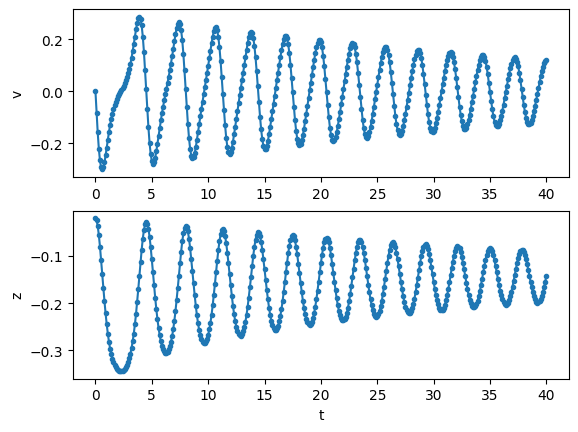

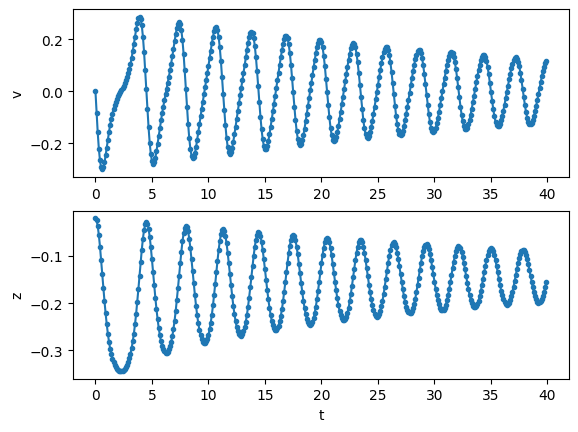

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-01 ...  3.990e+01  4.000e+01]
        y: [[ 0.000e+00 -8.238e-02 ...  1.180e-01  1.217e-01]
            [-2.000e-02 -2.415e-02 ... -1.543e-01 -1.422e-01]]
      sol: None
 t_events: [array([ 0.000e+00,  2.240e+00, ...,  3.783e+01,  3.924e+01])]
 y_events: [array([[ 0.000e+00, -2.000e-02],
                  [-5.204e-18, -3.442e-01],
                  ...,
                  [-2.776e-17, -8.666e-02],
                  [-6.245e-17, -1.989e-01]])]
     nfev: 2045
     njev: 0
      nlu: 0
----
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-01 ...  3.980e+01  3.990e+01]
        y: [[ 0.000e+00 -8.238e-02 ...  1.088e-01  1.180e-01]
            [-2.000e-02 -2.415e-02 ... -1.656e-01 -1.543e-01]]
      sol: None
 t_events: [array([ 0.000e+00,  2.240e+00, ...,  3.783e

In [73]:
S = resolve(y0=[0, -.02], events=eventoExtremo, RETORNA=True)
SEP = resolveEmPassos(y0=[0, -.02], tPIni=2.01, dtP=1., DTP=5., events=eventoExtremo, RETORNA=True)
print( S )
print( '----' )
print( SEP )

In [51]:
param = dict( t_span=[-1., 200.], dt=0.05, dtOff=0.05, amp=fazOff, DT=3., \
                SHOW=False, RETORNA=True, events=eventoExtremo )

In [52]:
S = resolve( **param, max_step=0.05/10 )
#print( S )

In [57]:
SEP = resolveEmPassos(tPIni=0., dtP=0.05, DTP=3., **param )
print( SEP )

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [-1.000e+00 -9.500e-01 ...  1.999e+02  2.000e+02]
        y: [[ 0.000e+00  0.000e+00 ...  1.726e-01  1.832e-01]
            [-1.397e-01 -1.397e-01 ... -1.983e-01 -1.894e-01]]
      sol: None
 t_events: [-1.000e+00 -1.000e+00 ...  1.978e+02  1.993e+02]
 y_events: [[ 0.000e+00 -1.397e-01]
            [ 0.000e+00 -1.397e-01]
            ...
            [-3.927e-15 -5.705e-02]
            [-1.034e-15 -2.530e-01]]
     nfev: 46998
     njev: 0
      nlu: 0


In [59]:
kwrd_dtP = dict( amp=lambda t,Y,**kwrd: 0 )
kwrd_DTP = dict( amp=lambda t,Y,**kwrd: 1.3 )
SEP_kwrd = resolveEmPassos(tPIni=0., dtP=0.05, DTP=3., \
                           kwrd_dtP=kwrd_dtP, kwrd_DTP=kwrd_DTP, **{**param,'SHOW':False} )
print( SEP_kwrd )

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [-1.000e+00 -9.500e-01 ...  1.999e+02  2.000e+02]
        y: [[ 0.000e+00  0.000e+00 ...  1.726e-01  1.832e-01]
            [-1.397e-01 -1.397e-01 ... -1.983e-01 -1.894e-01]]
      sol: None
 t_events: [-1.000e+00 -1.000e+00 ...  1.978e+02  1.993e+02]
 y_events: [[ 0.000e+00 -1.397e-01]
            [ 0.000e+00 -1.397e-01]
            ...
            [-8.049e-16 -5.705e-02]
            [-2.436e-15 -2.530e-01]]
     nfev: 12573
     njev: 0
      nlu: 0


In [43]:
SEP_RK = resolveEmPassos(tPIni=0., dtP=0.05, DTP=3., method='RK45', **param )
#print( SEP_RK)